# Очистка данных на примере датасета о квартирах в Москве

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.outliers import outliers_z_score_mod, outliers_iqr_mod

### Знакомство с данными

Подробнее о данных можно узнать [здесь](./README.md).

In [5]:
sber_data = pd.read_csv('data/sber_data.csv')
print('Shape of data: {}'.format(sber_data.shape))
sber_data.head()

Shape of data: (30471, 61)


,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


In [6]:
#display(sber_data.info());

### Обнаружение пропусков

In [7]:
display(sber_data.isnull().tail())

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
30466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30468,False,False,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
30469,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30470,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**1. Список столбцов с пропусками**

Первый способ — это вывести на экран названия столбцов, где число пропусков больше 0. 

In [8]:
cols_null_persent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

Итак, можно увидеть, что у нас большое число пропусков (более 47 %) в столбце hospital_beds_raion (количество больничных коек в округе). 

Далее у нас идут столбцы с числом пропусков чуть больше 20 %: 

* preschool_quota (число мест в детском саду в районе);
* school_quota (число мест в школах в районе);
* life_sq (жилая площадь здания в квадратных метрах). 

Менее одного процента пропусков содержат признаки:

* floor (число этажей в доме);
* metro_min_walk (время от дома до ближайшего метро пешком в минутах);
* metro_km_walk (расстояние до ближайшего метро в километрах);
* railroad_station_walk_km (расстояние до ближайшей ж. д. станции в километрах);
* railroad_station_walk_min (время до ближайшей ж. д. станции пешком в минутах). 

**2. Столбчатая диаграмма пропусков**

Иногда столбцов с пропусками становится слишком много и прочитать информацию о них из списка признаков с цифрами становится слишком затруднительно — цифры начинают сливаться воедино. 

Можно воспользоваться столбчатой диаграммой, чтобы визуально оценить соотношение числа пропусков к числу записей.

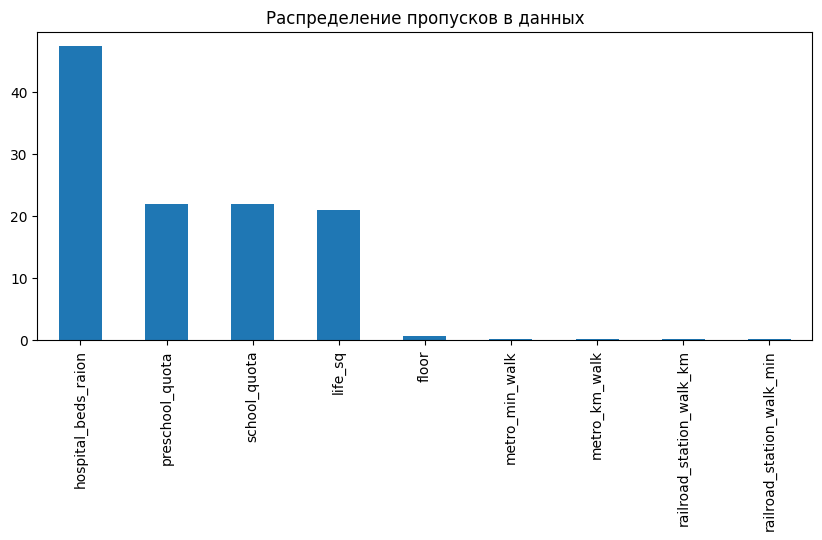

In [9]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

**3. Тепловая карта пропусков**

Ещё один распространённый способ визуализации пропусков — тепловая карта. 

Её часто используют, когда столбцов с пропусками не так много (меньше 10). Она позволяет понять не только соотношение пропусков в данных, но и их характерное местоположение в таблице. 

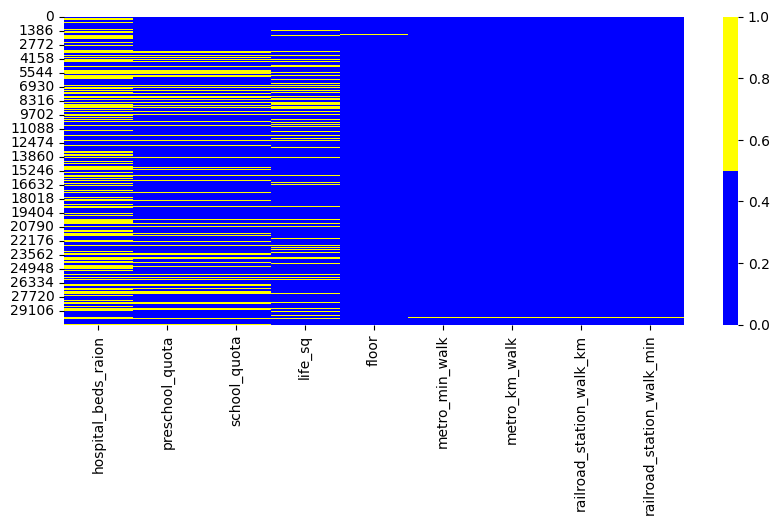

In [10]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

На полученной тепловой карте мы не видим чётких процентных соотношений для числа пропусков в данных, однако мы можем увидеть места их концентрации в таблице. Например, видно, что признаки preschool_quota и school_quota очень сильно связаны друг с другом по части пропусков: во всех записях, где хотя бы один не определён, не указан и второй (жёлтые линии для двух этих признаков полностью совпадают друг с другом).

### Методы обработки пропусков

**1. Отбрасывание записей и признаков**

Первая техника самая простая из всех, она предполагает простое удаление записей или признаков, в которых содержатся пропуски. Здесь важно правильно выбрать ось удаления: если мы избавимся от большого числа строк, то мы рискуем потерять важные данные, а если мы удалим столбцы, то мы можем потерять важные признаки.

<img src= https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/drop_na.jpg>

In [11]:
#создаем копию исходной таблицы
drop_data = sber_data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

In [12]:
drop_data.shape

(20888, 60)

Итак, мы удалили один столбец и ⅓ всех записей для того, чтобы избавиться от пропусков. Не слишком ли это много и что с этим можно сделать?

**2. Заполнение недостающих значений**

Другой способ бороться с пропусками - заполнить их константами. Чаще всего пустые места заполняют средним/медианой/модой для числовых признаков и модальным значением для категориальных признаков.

Недостаток данного метода - искажение истинных распределений признаков
<img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/fill_na.jpg>

Рассмотрим распределения признаков до заполнения

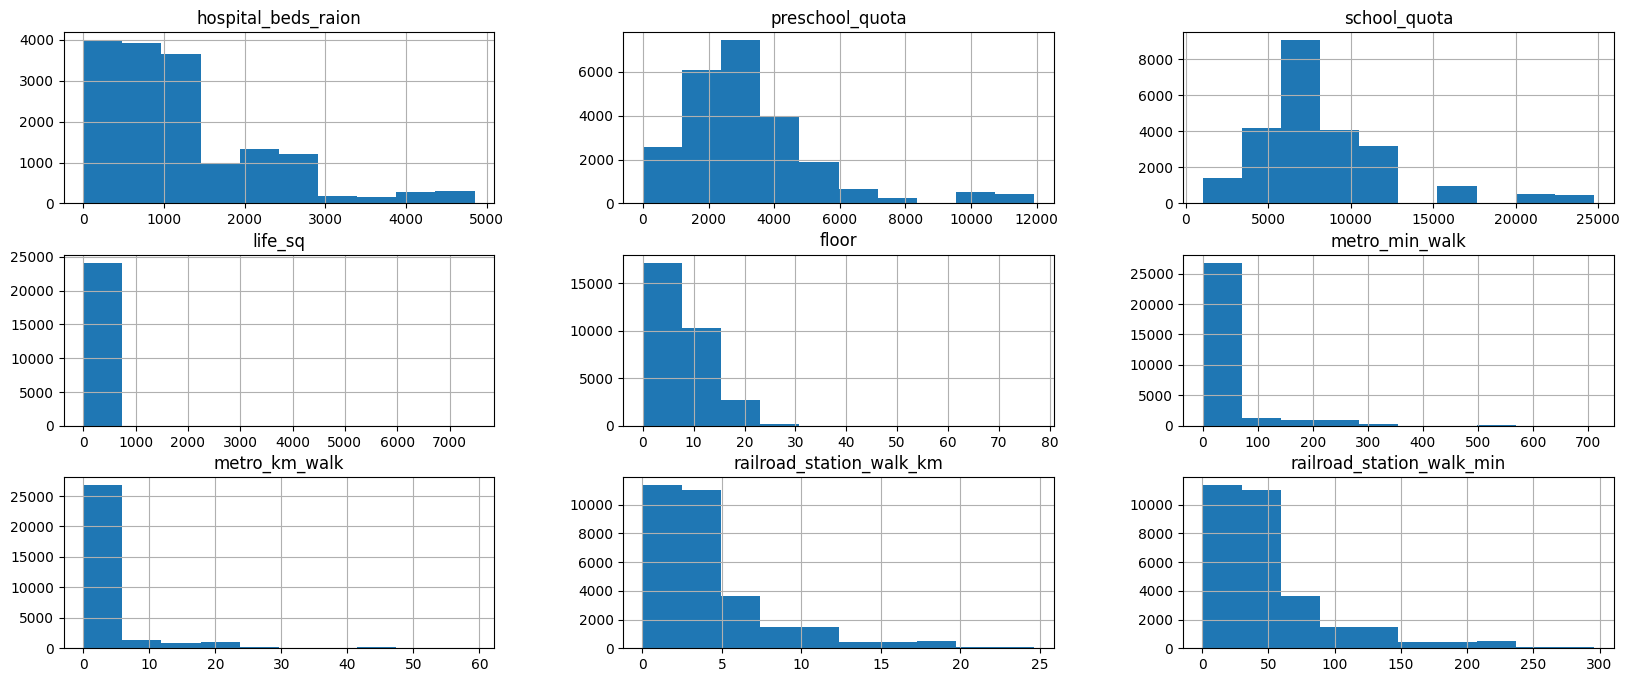

In [13]:
cols = cols_with_null.index
sber_data[cols].hist(figsize=(20, 8));

In [14]:
#создаем копию исходной таблицы
fill_data = sber_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

id                   0.0
full_sq              0.0
life_sq              0.0
floor                0.0
sub_area             0.0
                    ... 
theater_km           0.0
museum_km            0.0
ecology              0.0
mosque_count_1000    0.0
price_doc            0.0
Length: 61, dtype: float64

Рассмотрим распределения признаков после заполнения пропусков константами

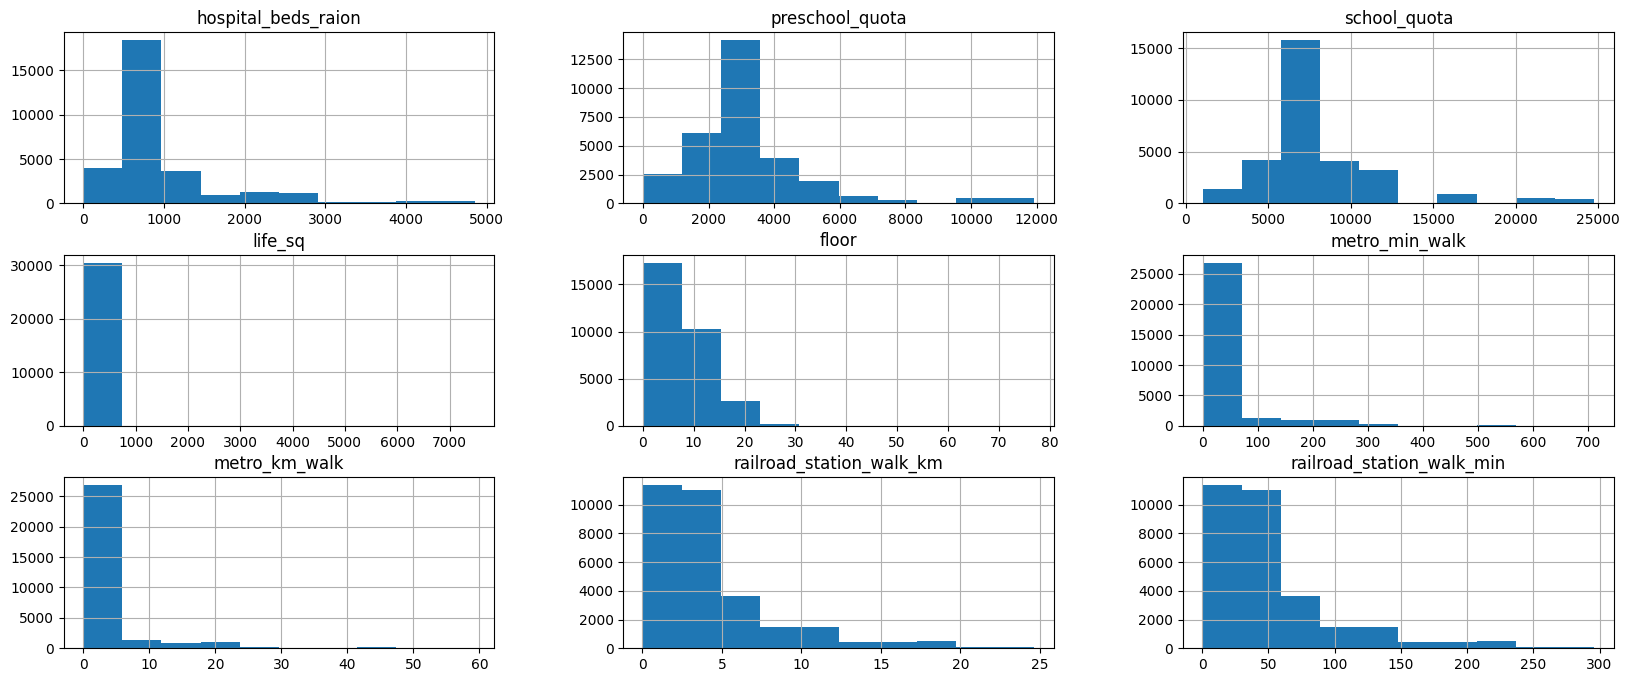

In [15]:
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 8));

Обратим внимание на то, как сильно изменилось распределение для признака hospital_beds_raion. Это связано с тем, что мы заполнили модальным значением почти 47 % общих данных. В результате мы кардинально исказили исходное распределение признака, что может плохо сказаться на модели.

**3. Заполнение недостающих значений с добавлением признака-индикатора**

Если мы используем заполнение пропусков константами, то может имеет смысл сказать модели о том, что на этом месте был пропуск? Давайте добавим к нашим данным признаки-индикаторы, которые будут сигнализировать о том, что в столбце на определенном месте в таблице был пропуск, это место в столбце- индикаторе будем помечать как True. Эта эвристика пытается снизить влияние искажения признака, указав модели на места, где мы "нафантазировали" данные.

<img src=https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/indicator_na.jpg>

In [16]:
#создаем копию исходной таблицы
indicator_data = sber_data.copy()
#в цикле пробегаемся по названиям столбцов с пропусками
for col in cols_with_null.index:
    #создаем новый признак-индикатор как col_was_null
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски   
values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
indicator_data = indicator_data.fillna(values)
#выводим результирующую долю пропусков
indicator_data.isnull().mean()

id                                    0.0
full_sq                               0.0
life_sq                               0.0
floor                                 0.0
sub_area                              0.0
                                     ... 
floor_was_null                        0.0
metro_min_walk_was_null               0.0
metro_km_walk_was_null                0.0
railroad_station_walk_km_was_null     0.0
railroad_station_walk_min_was_null    0.0
Length: 70, dtype: float64

Метод исходит из предположения, что, если дать модели информацию о том, что в ячейке ранее была пустота, то она будет меньше доверять таким записям и меньше учитывать её в процессе обучения. Иногда такие фишки действительно работают, иногда не дают эффекта, а иногда и вовсе могут ухудшить результат обучения и затруднить процесс обучения.

In [17]:
display(indicator_data.head())

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,price_doc,hospital_beds_raion_was_null,preschool_quota_was_null,school_quota_was_null,life_sq_was_null,floor_was_null,metro_min_walk_was_null,metro_km_walk_was_null,railroad_station_walk_km_was_null,railroad_station_walk_min_was_null
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,5850000,False,False,False,False,False,False,False,False,False
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,6000000,False,False,False,False,False,False,False,False,False
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,5700000,False,False,False,False,False,False,False,False,False
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,13100000,True,False,False,False,False,False,False,False,False
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,16331452,False,False,False,False,False,False,False,False,False


**4. Комбинирование методов**

Методы можно комбинировать. Например, мы можем:

* удалить столбцы, в которых более 30 % пропусков;
* удалить записи, в которых более двух пропусков одновременно;
* заполнить оставшиеся ячейки константами.

In [18]:
#создаем копию исходной таблицы
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

#создаем словарь имя столбца: число(признак) на который надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

In [19]:
print(combine_data.shape)

(26800, 60)


### Методы выявления выбросов

**1. Использование статистики и здравого смысла**

Это самый трудоёмкий метод, основанный на житейской логике, методе пристального взгляда и небольшом количестве статистики. Он предполагает поиск невозможных и нелогичных значений в данных.

Пусть у нас есть признак, по которому мы будем искать выбросы. Давайте рассчитаем его статистические показатели (минимум, максимум, среднее, квантили) и по ним попробуем определить наличие выбросов.

In [20]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

Что нам говорит метод describe()? Во-первых, у нас есть квартиры с нулевой жилой площадью. Во-вторых, в то время как 75-й квантиль равен 43, максимум превышает 7 тысяч квадратных метров (целый дворец, а не квартира!). 

In [21]:
print(sber_data[sber_data['life_sq'] == 0].shape[0])

45


Таких помещений оказывается 45 штук. Что это за зверь?

Это могут быть апартаменты — вид коммерческой недвижимости, которая юридически не является жилой площадью, но законно продаётся по ценам, сопоставимым с квартирными. Оставим их в покое.    

А теперь выведем здания с жилой площадью более 1 000 квадратных метров:

In [22]:
display(sber_data[sber_data['life_sq'] > 1000])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


Выброс налицо: гигантская жилая площадь (life_sq), да ещё почти в 100 раз превышает общую площадь (full_sq).

Логичен вопрос: а много ли у нас таких квартир, у которых жилая площадь больше, чем суммарная?

Давайте проверим это с помощью фильтрации:

In [23]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


Таких квартир оказывается 37 штук. Подобные наблюдения уже не поддаются здравому смыслу — они являются ошибочными, и от них стоит избавиться:

In [24]:
cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число записей: 30434


Ещё пример: давайте посмотрим на признак числа этажей (floor).

In [25]:
display(sber_data['floor'].describe())

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

Снова видим подозрительную максимальную отметку в 77 этажей. Проверим все квартиры, которые находятся выше 50 этажей:

In [26]:
sber_data[sber_data['floor']> 50]

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


Всего одна квартира в Ломоносовском районе. Пора идти в интернет в поиске самых высоких зданий в Москве! 

Убеждаемся в том, что здания выше 70 этажей находятся на территории комплекса Москва-Сити (Пресненский район). В Ломоносовском районе таких жилых высоток нет. Получается, что данное наблюдение — выброс.

**2. Метод межквартильного размаха**

Данный метод относится к категории статистических и реализован в виде отдельной python-функции в дирректории find_outliers в файле find_outliers.py.

Подробнее о методе можно в файле [README.md](./find_outliers/README.md)

In [27]:
from outliers_lib.find_outliers import find_outliers_iqr

На гистограмме мы можем увидеть потенциальные выбросы как низкие далеко отстоящие от основной группы столбцов «пеньки», а на коробчатой диаграмме — точки за пределами усов.

Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq):

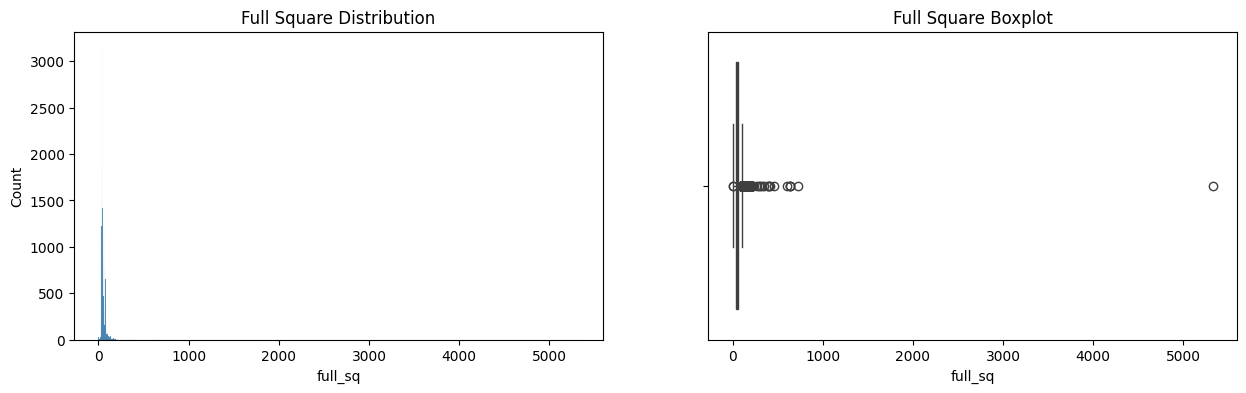

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

Основная масса квартир имеет общую площадь менее 250 квадратных метров, и лишь несколько невзрачных наблюдений выбиваются из этого интервала. Максимальная площадь, судя по гистограмме, превышает 5 000 квадратных метров.

Данные не являются нормально-распределенными, распределение даже не является симметричным. Попробуем логарифмировать признак:

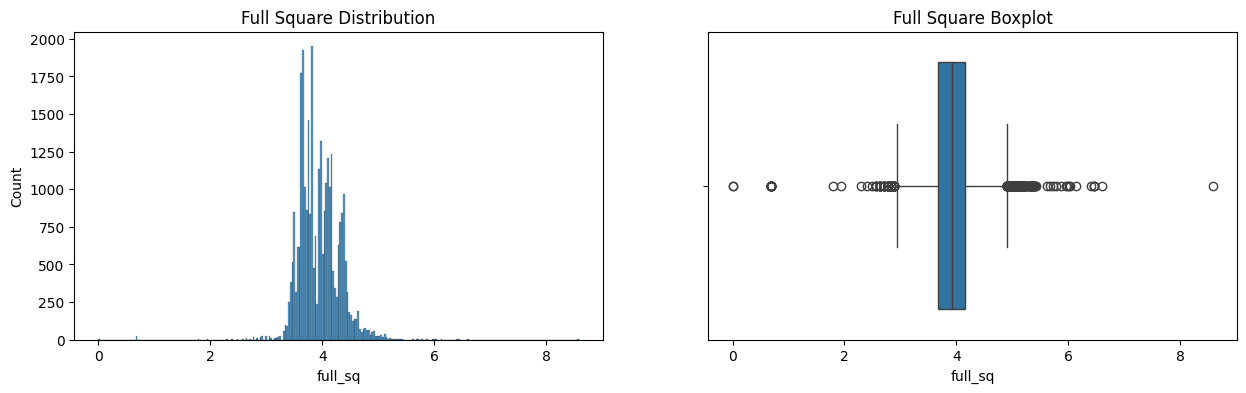

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x=np.log(sber_data['full_sq']+1), ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x=np.log(sber_data['full_sq']+1), ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

С помощью логарифмирования удалось добиться подобия симметрии в данных.

Воспользуемся методом межквартильного размаха с предварительным логарифмированием и 2-мя размахами в левую и правую сторону распределения. 

In [30]:
outliers, cleaned = find_outliers_iqr(sber_data, 'full_sq', left=2, right=2, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 111
Результирующее число записей: 30360


Посмотрим на распределение после удаления выбросов:

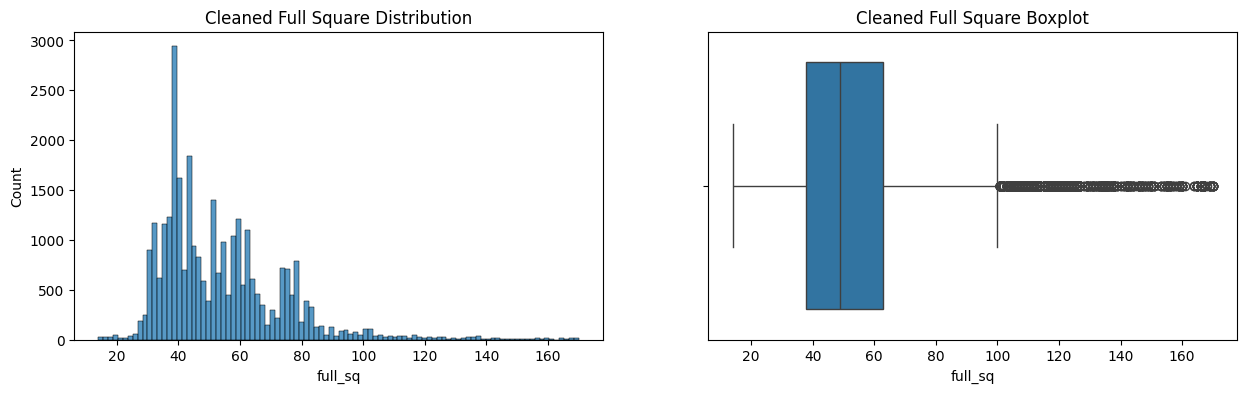

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

**3. Метод z-отклонений**

Данный метод также относится к категории статистических и реализован в виде отдельной python-функции в дирректории find_outliers в файле find_outliers.py.

Подробнее о методе можно в файле [README.md](./find_outliers/README.md)

In [32]:
from outliers_lib.find_outliers import find_outliers_z_score

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом.

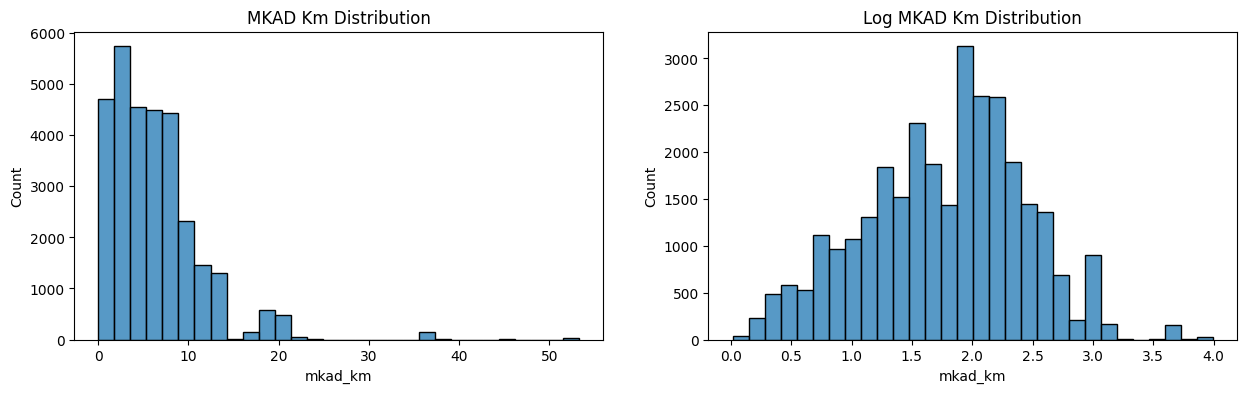

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

Левое распределение напоминает логнормальное распределение с наличием потенциальных выбросов-«пеньков», далеко отстоящих от основной массы наблюдений.

Взяв натуральный логарифм от левого распределения, мы получаем правое, которое напоминает слегка перекошенное нормальное.

Воспользуемся методом z отклонений с предварительным логарифмированием:

In [34]:
outliers, cleaned = find_outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


Построим гистограмму очищенных данных:

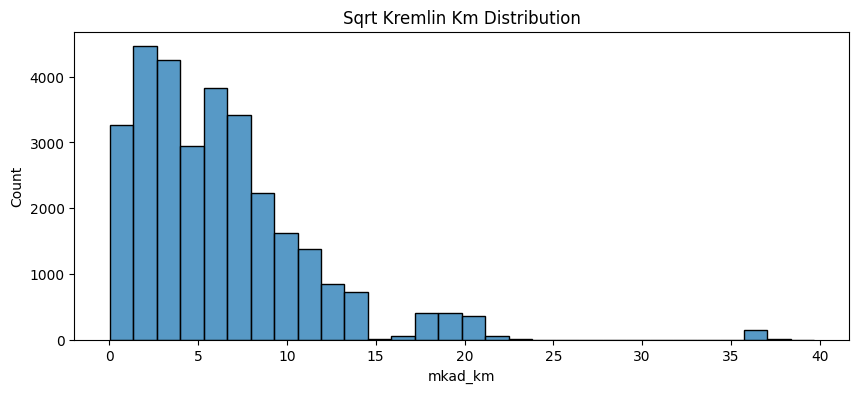

In [35]:
fig = plt.figure(figsize=(10, 4))
histplot = sns.histplot(cleaned['mkad_km'], bins=30)
histplot.set_title('Sqrt Kremlin Km Distribution');

Итак, метод z-отклонения нашел нам 33 потенциальных выброса по признаку расстояния до МКАД. Узнаем, в каких районах (sub_area) представлены эти квартиры:

In [36]:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


Наши потенциальные выбросы — это квартиры из поселений «Роговское» и «Киевский». Снова обращаемся к силе интернета и «пробиваем» наших подозреваемых. Эти поселения — самые удалённые районы Московской области; первое из них — это и вовсе граница с Калужской областью. 

И тут возникает закономерный вопрос: а стоит ли считать такие наблюдения за выбросы? 

Вопрос в действительности не имеет определенного ответа: с одной стороны, метод прямо-таки говорит нам об этом, а с другой — эти наблюдения имеют право на существование, ведь они являются частью Московской области.

Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала 

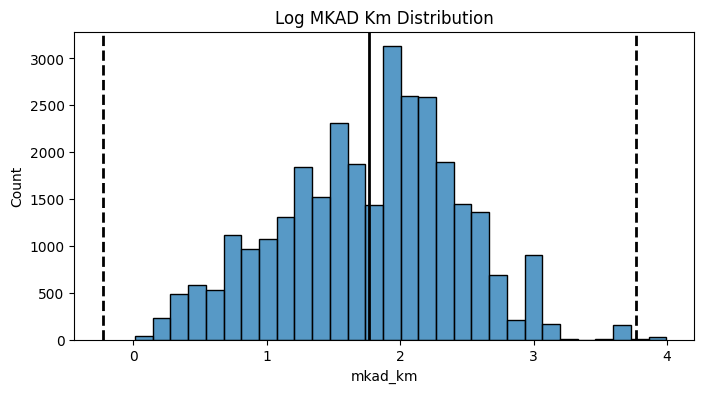

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean() + 3 *log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean() - 3 *log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

Ассиметрия распределения является левой. В этом можно убедиться, вычислив коэффициент ассиметрии:

In [38]:
print(log_mkad_km.skew())

-0.14263612203024953


Из графика видно, что из-за левой ассиметриии 3ех сигм не достаточно, чтобы покрыть весь интервал. Увеличим значения границ:

In [39]:
outliers, cleaned = find_outliers_z_score(sber_data, 'mkad_km', log_scale=True, right=3.5)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


Стоило нам немного увеличить правую границу метода z-отклонений, как мы получили отсутствие выбросов в признаке.

### Поиск и ликвидация дубликатов

Способ обнаружения дубликатов зависит от того, что именно вы считаете дубликатом. Например, за дубликаты можно посчитать записи, у которых совпадают все признаки или их часть. Если в таблице есть столбец с уникальным идентификатором (id), вы можете попробовать поискать дубликаты по нему: одинаковые записи могут иметь одинаковый id.

Проверим, есть у нас такие записи: для этого сравним число уникальных значений в столбце id с числом строк. Число уникальных значений вычислим с помощью метода nunique():

In [40]:
sber_data['id'].nunique() == sber_data.shape[0]

True

Вроде бы всё в порядке: каждой записи в таблице соответствует свой уникальный идентификатор. Но это ещё не означает, что в таблице нет дубликатов!

Столбец с id задаёт каждой строке свой уникальный номер, поэтому сама по себе каждая строка является уникальной. Однако содержимое других столбцов может повторяться.

 Найдём число полных дубликатов таблице sber_data. Предварительно создадим список столбцов dupl_columns, по которым будем искать совпадения (все столбцы, не включая id). 

In [41]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


Итак, 562 строки в таблице являются полными копиями других записей. Теперь нам необходимо от них избавиться.

In [42]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909
